# RRTs in Python

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 8, 8
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
def render_trimesh(vertices, indices, edgecolor = 'r', facecolor = 'r'):
    import matplotlib.collections as collections
    vertices = np.asarray(vertices)
    indices = np.asarray(indices)
    data = np.zeros((indices.shape[0], 3, 2))
    for i in xrange(indices.shape[0]):
        data[i] = vertices[ indices[i], :]
    col = collections.PolyCollection(data)
    col.set_facecolor(facecolor)
    col.set_edgecolor(edgecolor)
    col.set_alpha(0.5)
    col.set_linewidth(1)
    return col


def rot_z(theta):
    '''Counter-clockwise rotation about the z-axis
    
    Parameters
    ----------
    theta : float
        rotation angle in radians (+ve is counter clockwise)
    
    Returns
    -------
    m : matrix
        a 3x3 rotation matrix
    '''
    ct = np.cos(theta)
    st = np.sin(theta)
    m = np.array([
            [ct, -st, 0.],
            [st,  ct, 0.],
            [0.,  0., 1.]
        ])
    return m

In [3]:
import pypqp

class Geometry(pypqp.PQP_Model):
    def __init__(self, pts, indices):
        pts = np.asarray(pts, dtype='float')
        ptsz = np.zeros((pts.shape[0], 3))
        for i in xrange(min(3, pts.shape[1])):
            ptsz[:, i] = pts[:, i]
        pts = ptsz
        indices = np.asarray(indices, dtype='int')
        us = pts[indices[:, 0], :]
        vs = pts[indices[:, 1], :]
        ws = pts[indices[:, 2], :]
        self._pts = pts
        self._is = indices
        super(Geometry, self).__init__(us, vs, ws)
        
    def render(self, q, ax = None, **kwargs):
        rot = rot_z(q[2])
        trans = q[0:2]
        print trans
        if ax is None:
            ax = plt.gca()
        pts = np.dot(rot, self._pts.T).T
        pts = pts[:, [0, 1]] + trans
        ax.add_collection( render_trimesh( pts, self._is, **kwargs))


In [31]:
def build_world():
    s = 4.0
    d = 2.0
    x = 1.0

    points = [
        [-s-d, -s-d], # 0
        [ s+d, -s-d], # 1
        [ s+d,  s+d], # 2
        [-s-d,  s+d], # 3
        [ -s,  -s], # 4
        [  s,  -s], # 5
        [ s,  s], # 6
        [ -s,  s], # 7
        [-x, -x],
        [-x, x],
        [ x, x],
        [ x, -x],
    ]

    inds = [
        [0, 1, 5],
        [0, 5, 4],
        [1, 2, 5],
        [5, 6, 2],
        [2, 3, 6],
        [3, 6, 7],
        [0, 3, 4],
        [3, 4, 7],
        [8, 9, 10],
        [8, 10, 11],
    ]

    g = Geometry(points, inds)
    return g

def build_vehicle():
    vpts = [
        [-0.5, 0],
        [ 0.5, 0],
        [ 0.0, 1.0],
    ]
    v = Geometry(vpts, [[0,1,2]])
    return v
    
def square():
    pts = np.array([
        [0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [0., 1., 0.],
    ])
    inds = np.array([
        [0, 1, 2],
        [2, 3, 0]
    ])

    g = Geometry(pts, inds)
    return g

In [5]:
class RRT(object):
    
    def random_configuration(self):
        '''Generate a non-collision random configuration
        
        Returns
        -------
        array-like
            the randomly generated (non-collision) configuration
        '''
        raise NotImplemented()
    
    def nearest_vertex(self, q, qs):
        '''Identify the nearest vertex in terms of a metric 
        
        Parameters
        ----------
        q : array-like
            (n,) a sampled configuration
        qs : array-like
            pre-existing configurations
        
        Returns
        -------
        int
            the index of qs the q is closes to according to a metric
        '''
        raise NotImplemented()
    
    def new_configuration(self, q_new, q_rand):
        raise NotImplemented()
    
    def plan(self, q_init, k):

        # We'll maintain a cache of configurations
        configurations = np.zeros((k, q_init.shape[0]))
        
        # We'll use a directed graph to store the tree
        G = nx.DiGraph()
                
        # Ensure that the initial configuration is array-like
        q_init = np.asarray(q_init)
        
        # Insert the initial configuration
        G.add_node(0)
        configurations[0, :] = q_init
        
        # Loop for fixed number of attempts
        for i in xrange(1, k):
            q_rand = self.random_configuration()
            i_near = self.nearest_vertex(q_rand, configurations)
            q_near = configurations[i_near, :]
            q_new = self.new_configuration(q_near, q_rand)
            G.add_node(i)
            configurations[i, :] = q_new
            G.add_edge(i_near, i)
            
        self._insert_configuration_metadata(G, configurations)
        return G

    def _insert_configuration_metadata(self, G, configurations):
        qs = {}
        for i in G.nodes():
            qs[i] = configurations[i, :]
        nx.set_node_attributes(G, 'configuration', qs)
        return G        

    def plot(self):
        pass

In [6]:
# We'll define *all* of this through mixins
# because all of these behaviors are independent
# and this allows maximum composability
    
class FullLengthExtension(object):
    def new_configuration(self, q_near, q_rand):
        return q_rand
    
class UniformRandomSampler(object):
    def random_configuration(self):
        return np.random.uniform(low = 0.0, high = 1.0, size = 2)

class NaiveMinimumDistance(object):
    def nearest_vertex(self, q, configurations):
        # Euclidean metric
        dq = configurations - q
        ds = np.sum(dq**2, axis=1)
        i = np.argmin(ds)
        return i

class StraightLinePlot(object):
    def plot(self, G):
        pos = { i : ps['configuration'] for i, ps in G.nodes(data = True) }
        nx.draw_networkx_edges(G, pos = pos, arrows=False)
        plt.gca().set_xlim(-0.1, 1.1)
        plt.gca().set_ylim(-0.1, 1.1)
        plt.gca().set_aspect('equal')
        

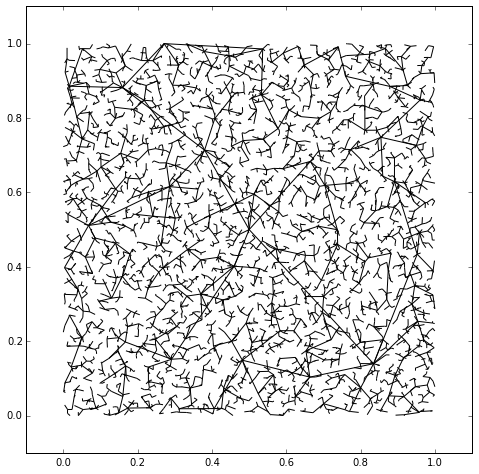

In [7]:
class ExplorationRRT(UniformRandomSampler, 
             #EuclideanDistanceMetric, 
             NaiveMinimumDistance, 
             FullLengthExtension,
             StraightLinePlot,
             RRT):
    def __init__(self):
        super(ExplorationRRT, self).__init__()
        
toy = ExplorationRRT()
q_init = np.array([0.5, 0.5])
G = toy.plan(q_init, 5000)
toy.plot(G)

[ 0.  0.]
[ 3.5 -3. ]


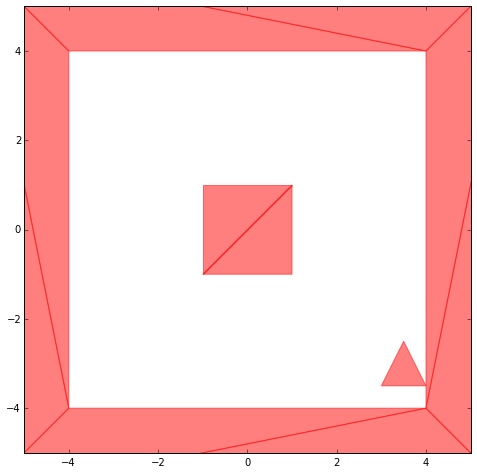

In [8]:
world = build_world()
robot = build_vehicle()
    
plt.figure()
ax = plt.gca()
world.render(np.zeros(3), ax = ax)
robot.render(np.array([3.5, -3.0, 0]), ax = ax)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.show()

In [25]:
class WorldRandomSampler(object):
    def __init__(self, **kwargs):
        self._world = kwargs['world']
        self._robot = kwargs['robot']
    
    def is_in_collision(self, q):
        q3 = np.zeros(3)
        q3[:2] = q
        I = np.identity(3)
        z = np.zeros(3)
        return pypqp.colliding(I, z, self._world, I, q3, self._robot) == 1
    
    def random_configuration(self):
        q = np.random.uniform(low = -5, high = 5.0, size = 2)
        while self.is_in_collision(q):
            q = np.random.uniform(low = -5, high = 5.0, size = 2)
        return q
         

(10000, 2)
[ 0.  0.]
[ 3.5 -3. ]


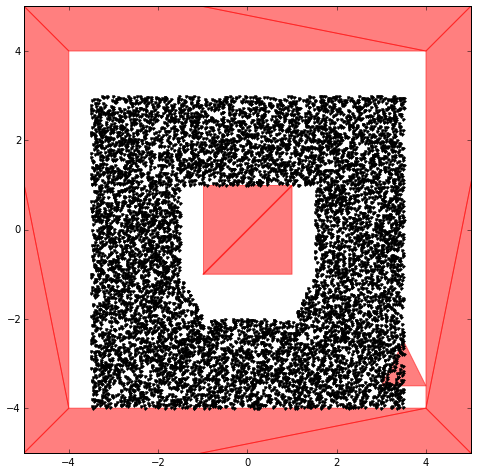

In [32]:
s = WorldRandomSampler(world = build_world(), robot = build_vehicle())
xys = []
for i in xrange(10000):
    xy = s.random_configuration()
    xys.append(xy)
xys = np.vstack(xys)
print xys.shape

plt.figure()
ax = plt.gca()
world.render(np.zeros(3), ax = ax)
robot.render(np.array([3.5, -3.0, 0]), ax = ax)
ax.plot(xys[:,0], xys[:,1], 'k.')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.show()

